In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.arima_process as arima_process
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, make_column_selector
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import plotly.express as px
import pyodbc


In [2]:
data = pd.read_csv('data/vehicles.csv')

In [3]:
data.drop(data[(data['year'].isna() & data['VIN'].isna())].index,inplace=True)

In [4]:
data = data.convert_dtypes()

In [5]:
data.drop(data[data['price']>500000].index,inplace=True)
data.drop(data[data['price']<1000].index,inplace=True)

In [6]:
data.region.fillna('',inplace=True)
data.manufacturer.fillna('',inplace=True)
data.model.fillna('',inplace=True)
data.model = data.model.str.lower()
data.condition.fillna('',inplace=True)
data.title_status.fillna('',inplace=True)
data.transmission.fillna('',inplace=True)
data.VIN.fillna('',inplace=True)
data.fuel.fillna('',inplace=True)
data.drive.fillna('',inplace=True)
data['size'].fillna('',inplace=True)
data['type'].fillna('',inplace=True)
data.paint_color.fillna('',inplace=True)
data.year.fillna(-1,inplace=True)
data.odometer.fillna(-1,inplace=True)
data.cylinders.fillna('',inplace=True)

In [7]:
for col in data.select_dtypes(exclude=['Int64','Float64']).columns:
    data[col] = data[col].str.strip()

In [8]:
# conn = pyodbc.connect(driver='{ODBC Driver 17 for SQL Server}', server='RICKMSILAPTOP\SQL2022', database='master', trusted_connection='yes')
# data_vins = pd.read_sql(sql='SELECT * FROM vpiclist_lite1.dbo.VinsRead', con=conn)
# data_vins.sort_values('pdindex',inplace=True)
# data_vins.set_index('pdindex', drop=True, inplace=True)
# #data_vins.rename(columns={'Make':'make','Model':'model','ModelYear':'year','Cylinders':'cylinders','FuelType':'fuel','DriveType':'drive','BodyClass':'type'},inplace=True)
# data_vins = data_vins.astype('string')
# data_vins.id = data_vins.id.astype('Int64')
# data_vins.ModelYear = data_vins.ModelYear.astype('Int64')
# data_vins.Doors = data_vins.Doors.astype('Int64')
# data_vins.Cylinders = data_vins.Cylinders.astype('Int64')
# data_vins.Displacement = data_vins.Displacement.astype('Float64')
# data_vins.Make.fillna('',inplace=True)
#data_vins.to_csv('data/vins_lookup.csv')

In [30]:
data_vins = pd.read_csv('data/vins_lookup.csv')

In [10]:
data.info()  #380437 

<class 'pandas.core.frame.DataFrame'>
Index: 380437 entries, 27 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            380437 non-null  Int64 
 1   region        380437 non-null  string
 2   price         380437 non-null  Int64 
 3   year          380437 non-null  Int64 
 4   manufacturer  380437 non-null  string
 5   model         380437 non-null  string
 6   condition     380437 non-null  string
 7   cylinders     380437 non-null  string
 8   fuel          380437 non-null  string
 9   odometer      380437 non-null  Int64 
 10  title_status  380437 non-null  string
 11  transmission  380437 non-null  string
 12  VIN           380437 non-null  string
 13  drive         380437 non-null  string
 14  size          380437 non-null  string
 15  type          380437 non-null  string
 16  paint_color   380437 non-null  string
 17  state         380437 non-null  string
dtypes: Int64(4), string(14)
memo

In [33]:
data_vins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 265838 entries, 27 to 426879
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            265838 non-null  int64  
 1   VIN           265838 non-null  object 
 2   ErrorCode     265838 non-null  object 
 3   Make          263891 non-null  object 
 4   Model         263585 non-null  object 
 5   ModelYear     263883 non-null  float64
 6   BodyClass     263597 non-null  object 
 7   Doors         207630 non-null  float64
 8   GW            217049 non-null  object 
 9   DriveType     192061 non-null  object 
 10  Cylinders     240976 non-null  float64
 11  Displacement  261168 non-null  float64
 12  FuelType      256983 non-null  object 
 13  Series        182673 non-null  object 
 14  Trim          108654 non-null  object 
 15  CabType       162601 non-null  object 
 16  size          0 non-null       float64
dtypes: float64(5), int64(1), object(11)
memory usage: 36

In [32]:
data_vins.set_index('pdindex',inplace=True)

In [12]:
data_vins.GW.value_counts()

GW
class 1: 6,000 lb or less (2,722 kg or less)          46614
class 2e: 6,001 - 7,000 lb (2,722 - 3,175 kg)         43080
class 1d: 5,001 - 6,000 lb (2,268 - 2,722 kg)         38171
class 1c: 4,001 - 5,000 lb (1,814 - 2,268 kg)         32316
class 2f: 7,001 - 8,000 lb (3,175 - 3,629 kg)         20304
class 2h: 9,001 - 10,000 lb (4,082 - 4,536 kg)        11847
class 3: 10,001 - 14,000 lb (4,536 - 6,350 kg)         8172
class 1b: 3,001 - 4,000 lb (1,360 - 1,814 kg)          5792
class 2g: 8,001 - 9,000 lb (3,629 - 4,082 kg)          4854
class 5: 16,001 - 19,500 lb (7,258 - 8,845 kg)         1731
class 2: 6,001 - 10,000 lb (2,722 - 4,536 kg)          1423
class 4: 14,001 - 16,000 lb (6,350 - 7,258 kg)          994
class 6: 19,501 - 26,000 lb (8,845 - 11,794 kg)         678
class 7: 26,001 - 33,000 lb (11,794 - 14,969 kg)        461
class 8: 33,001 lb and above (14,969 kg and above)      385
class 1a: 3,000 lb or less (1,360 kg or less)           227
Name: count, dtype: int64

In [13]:
data_vins.Series.value_counts()

Series
super duty - single rear wheel    5932
se                                5059
lx                                3158
3-series                          3000
1/2 ton                           2689
                                  ... 
construction                         1
sr                                   1
ext. ls apv (+y91)                   1
131 (13 sections +10")               1
performance w/navigation (awd)       1
Name: count, Length: 2581, dtype: int64

In [14]:
data_vins.loc[data_vins['BodyClass']=='pickup'].CabType.value_counts()

CabType
crew/super crew/crew max                 34931
extra/super/quad/double/king/extended    18105
regular                                   3573
mega                                       121
Name: count, dtype: int64

In [15]:
data_vins.BodyClass.value_counts()

BodyClass
sport utility vehicle (suv)/multi-purpose vehicle (mpv)                                                          78826
sedan/saloon                                                                                                     65280
pickup                                                                                                           62413
hatchback/liftback/notchback                                                                                     13053
coupe                                                                                                            12248
convertible/cabriolet                                                                                             6456
minivan                                                                                                           5751
crossover utility vehicle (cuv)                                                                                   4158
cargo van                             

In [16]:
data.loc[data.id.isin(data_vins.loc[data_vins.ModelYear.isna()]['id']),'VIN'] = 'bad'
for col in data_vins.select_dtypes(exclude=['Int64','Float64']).columns:
    data_vins[col] = data_vins[col].str.lower()
    
data_vins.loc[data_vins.Make=='alfa romeo','Make']='alfa-romeo'

In [17]:
data = data.merge(data_vins[['id','Make','BodyClass','CabType','GW']], how='inner',on='id')
data.loc[~data['Make'].isna(),'manufacturer'] = data.Make
data.drop(data.loc[data.manufacturer==''].index,inplace=True)
data.drop(columns='Make',inplace=True)
#data['manufacturer'].value_counts()[data['manufacturer'].value_counts() < 180]
#data['manufacturer'].value_counts()[data['manufacturer'].value_counts() < 180].sum()
data.drop(data.loc[data.manufacturer.isin(data['manufacturer'].value_counts()[data['manufacturer'].value_counts() < 18].index)].index, inplace=True)

In [18]:
data = data.merge(data_vins[['id','Model']], how='inner',on='id')
data.loc[~data['Model'].isna(),'model'] = data['Model']
data.drop(data.loc[data.model==''].index,inplace=True)
data.drop(columns='Model',inplace=True)
#data['model'].value_counts()[data['model'].value_counts() < 180]
#data['model'].value_counts()[data['model'].value_counts() < 180].sum()
data.drop(data.loc[data.model.isin(data['model'].value_counts()[data['model'].value_counts() < 18].index)].index, inplace=True)


In [19]:
#data['condition'].value_counts()
data.drop(data.loc[data['condition']=='salvage'].index,inplace=True)
data.loc[data.condition=='new','condition'] = '9'
data.loc[data.condition=='like new','condition'] = '7'
data.loc[data.condition=='excellent','condition'] = '5'
data.loc[data.condition=='good','condition'] = '3'
data.loc[data.condition=='fair','condition'] = '1'
data.loc[data.condition=='','condition'] = '4'
#data['condition'].value_counts()[data['condition'].value_counts() < 500]
data.condition = data.condition.astype('Int64')

In [20]:
data.cylinders = data.cylinders.str.replace(r'[^0123456789]', '', regex=True)

In [21]:
pd.options.display.max_rows = 20
pd.options.display.max_columns = 0

In [22]:
data['cylinders'].value_counts()

cylinders
      104660
6      51452
8      36482
4      35889
5        742
10       677
3        306
12        54
Name: count, dtype: Int64

In [35]:
data.fuel.value_counts()

fuel
gas         183589
other        25748
diesel       14383
hybrid        2967
              2379
electric      1196
Name: count, dtype: Int64

In [36]:
data.loc[data.fuel=='','fuel'] = 'gas'

In [37]:
data.title_status.value_counts()

title_status
clean         220938
                6324
rebuilt         1929
salvage          843
lien             207
missing           18
parts only         3
Name: count, dtype: Int64

In [38]:
data.drop(columns='title_status',inplace=True)

In [39]:
data.transmission.value_counts()

transmission
automatic    161601
other         59203
manual         7792
               1666
Name: count, dtype: Int64

In [40]:
data.loc[data.transmission=='other','transmission'] = 'automatic'
data.loc[data.transmission=='','transmission'] = 'automatic'

In [41]:
data.drive.value_counts()

drive
4wd    75623
       63099
fwd    61001
rwd    30539
Name: count, dtype: Int64

In [42]:
data = data.merge(data_vins[['id','DriveType']], how='inner',on='id')

In [43]:
data.loc[(data.drive=='') & (data.DriveType == '4wd/4-wheel drive/4x4'),'drive'] = '4wd'
data.loc[(data.drive=='') & (data.DriveType == '4x2'),'drive'] = 'rwd'
data.loc[(data.drive=='') & (data.DriveType == 'awd/all-wheel drive'),'drive'] = 'awd'
data.loc[(data.drive=='') & (data.DriveType == 'fwd/front-wheel drive'),'drive'] = 'fwd'
data.loc[(data.drive=='') & (data.DriveType == 'rwd/rear-wheel drive'),'drive'] = 'rwd'
data.loc[(data.drive=='') & (data.DriveType == '2wd/4wd'),'drive'] = 'awd'
data.loc[(data.drive=='') & (data.DriveType == '6x4'),'drive'] = '4wd'
data.drop(data.loc[(data.drive=='') & (data.DriveType == 'not applicable')].index,inplace=True)


In [44]:
data_max_drive = data.groupby(['manufacturer','model'])['drive'].value_counts().to_frame()
data_max_drive.reset_index(inplace=True)

In [45]:
data_max_drive2 = data_max_drive.groupby(['manufacturer','model'])['count'].max().to_frame()
#data_max_drive2.rename(columns={'count':'max'},inplace=True)
data_max_drive2 = data_max_drive2.merge(data_max_drive,on=['manufacturer','model','count'], how='inner')
data_max_drive2.drop(data_max_drive2.loc[data_max_drive2.drive==''].index,inplace=True)
data_max_drive2.drop(columns='count',inplace=True)
data_max_drive2.rename(columns={'drive':'drive_max'},inplace=True)

In [46]:
data = data.merge(data_max_drive2, on=['manufacturer','model'], how='inner')
data.loc[(data['drive']==''),'drive']=data.drive_max

In [47]:
data.drop(columns=['DriveType','drive_max'],inplace=True)

In [48]:
data_max_size = data.loc[(data.size!='') & (data.manufacturer!='') & (data.model!='')].groupby(['manufacturer','model'])['size'].value_counts().to_frame()
data_max_size.reset_index(inplace=True)
data_max_size.drop(data_max_size.loc[data_max_size['size']==''].index,inplace=True)
data_max_size2 = data_max_size.groupby(['manufacturer','model'])['count'].max().to_frame()
data_max_size2 = data_max_size2.merge(data_max_size,on=['manufacturer','model','count'], how='inner')
data_max_size2.drop(columns=['count'],inplace=True)
data_max_size2.rename(columns={'size':'size_max'},inplace=True)
data = data.merge(data_max_size2, on=['manufacturer','model'], how='inner')
#data.rename(columns={'size_x':'size','size_y':'size_max'},inplace=True)
data.loc[(data['size']==''),'size_max']=data.size_max
data.drop(columns='size_max',inplace=True)

In [49]:
data_max_type = data.loc[(data.type!='') & (data.manufacturer!='') & (data.model!='')].groupby(['manufacturer','model'])['type'].value_counts().to_frame()
data_max_type.reset_index(inplace=True)
data_max_type.drop(data_max_type.loc[data_max_type['type']==''].index,inplace=True)
data_max_type2 = data_max_type.groupby(['manufacturer','model'])['count'].max().to_frame()
data_max_type2 = data_max_type2.merge(data_max_type,on=['manufacturer','model','count'], how='inner')
data_max_type2.drop(columns=['count'],inplace=True)
data_max_type2.rename(columns={'type':'type_max'},inplace=True)
data = data.merge(data_max_type2, on=['manufacturer','model'], how='inner')
#data.rename(columns={'type_x':'type','type_y':'type_max'},inplace=True)
data.loc[(data['type']==''),'type_max']=data.type_max
data.drop(columns='type_max',inplace=True)

In [50]:
data['region'] = data[['region','state']].apply(lambda x: (x['region'] + ', ' + x['state']),axis=1)

In [51]:
data.GW = data.GW.str[:7]
data.GW = data.GW.str.replace(r'[^0123456789]', '', regex=True)
data.GW = data.GW.astype('Int64')
data.GW.value_counts()

GW
1    105844
2     70572
3      6891
5      1537
4       815
6       580
7       200
8        75
Name: count, dtype: Int64

Need to set empty strings to null for pca

In [52]:
data_nan = data.loc[data['BodyClass']=='pickup',['id','price','year','manufacturer','condition','fuel','odometer','drive','GW']]
data_nan.set_index('id',inplace=True,drop=True)

In [53]:
col_strings = pd.array(['manufacturer','fuel','drive'])

for col in col_strings:
    #print(col)
    data_nan.loc[data_nan[col]=='',col]=np.nan
    
col_num = pd.array(['price', 'year', 'condition','GW', 'odometer'])
for col in col_num:
    #print(col)
    data_nan.loc[data_nan[col]==0,col]=np.nan


In [54]:
data_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55897 entries, 7316814884 to 7316835728
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   price         55897 non-null  Int64 
 1   year          55897 non-null  Int64 
 2   manufacturer  55897 non-null  string
 3   condition     55897 non-null  Int64 
 4   fuel          55897 non-null  string
 5   odometer      55765 non-null  Int64 
 6   drive         55897 non-null  string
 7   GW            55892 non-null  Int64 
dtypes: Int64(5), string(3)
memory usage: 4.2 MB


In [55]:
data_nan.drop(data_nan.loc[data_nan['odometer'].isna()].index,inplace=True)
data_nan.drop(data_nan.loc[data_nan['GW'].isna()].index,inplace=True)

In [56]:
#data.columns
#columns_to_encode1 = ['fuel', 'drive', 'manufacturer','model','type'] # model using model was useless
columns_to_encode1 = ['manufacturer','fuel', 'drive']

In [57]:
data_dummies = pd.get_dummies(data_nan[columns_to_encode1])

In [58]:
columns_numeric = ['year','condition', 'odometer', 'GW']
data_norm = data_nan[columns_numeric]
data_norm = data_norm.merge(data_dummies,on='id')
data_norm = (data_norm - data_norm.mean()) / data_norm.std()
data_norm.describe()

,year,condition,odometer,GW,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_dodge,manufacturer_ford,manufacturer_gmc,manufacturer_honda,manufacturer_jeep,manufacturer_mazda,manufacturer_nissan,manufacturer_ram,manufacturer_subaru,manufacturer_toyota,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,drive_4wd,drive_awd,drive_fwd,drive_rwd
count,58950.0,58950.0,58950.0,58950.0,5.895000e+04,5.895000e+04,5.895000e+04,5.895000e+04,5.895000e+04,5.895000e+04,5.895000e+04,5.895000e+04,5.895000e+04,5.895000e+04,5.895000e+04,5.895000e+04,5.895000e+04,5.895000e+04,5.895000e+04,5.895000e+04,5.895000e+04,5.895000e+04,58950.000000,5.895000e+04,5.895000e+04
mean,-0.0,-0.0,0.0,0.0,-1.928530e-18,1.523539e-16,-3.471354e-17,2.429948e-16,1.137833e-16,-1.542824e-17,9.160517e-18,-7.714120e-18,2.892795e-18,1.542824e-16,7.714120e-18,-3.471354e-17,-4.049913e-17,4.459725e-18,8.678385e-18,-4.700792e-18,5.014178e-17,-4.387406e-17,0.000000,5.158817e-17,-1.157118e-17
std,1.0,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
min,-13.007149,-3.40827,-1.263256,-1.86639,-1.235688e-02,-4.861722e-01,-2.057401e-01,-7.854134e-01,-3.373371e-01,-8.097280e-02,-5.313991e-02,-1.975618e-02,-1.800467e-01,-3.977387e-01,-3.777493e-02,-3.429244e-01,-4.456249e-01,-7.133885e-03,-1.540631e+00,-2.437347e-02,-3.867118e-01,-1.523757e+00,-0.021799,-1.709573e-01,-6.114960e-01
25%,0.062497,-1.027336,-0.849974,0.152023,-1.235688e-02,-4.861722e-01,-2.057401e-01,-7.854134e-01,-3.373371e-01,-8.097280e-02,-5.313991e-02,-1.975618e-02,-1.800467e-01,-3.977387e-01,-3.777493e-02,-3.429244e-01,-4.456249e-01,-7.133885e-03,-1.540631e+00,-2.437347e-02,-3.867118e-01,-1.523757e+00,-0.021799,-1.709573e-01,-6.114960e-01
50%,0.081975,0.163131,-0.201163,0.152023,-1.235688e-02,-4.861722e-01,-2.057401e-01,-7.854134e-01,-3.373371e-01,-8.097280e-02,-5.313991e-02,-1.975618e-02,-1.800467e-01,-3.977387e-01,-3.777493e-02,-3.429244e-01,-4.456249e-01,-7.133885e-03,6.490738e-01,-2.437347e-02,-3.867118e-01,6.562614e-01,-0.021799,-1.709573e-01,-6.114960e-01
75%,0.101453,0.163131,0.689369,0.152023,-1.235688e-02,-4.861722e-01,-2.057401e-01,1.273193e+00,-3.373371e-01,-8.097280e-02,-5.313991e-02,-1.975618e-02,-1.800467e-01,-3.977387e-01,-3.777493e-02,-3.429244e-01,-4.456249e-01,-7.133885e-03,6.490738e-01,-2.437347e-02,-3.867118e-01,6.562614e-01,-0.021799,-1.709573e-01,1.635306e+00
max,0.120931,6.115466,14.457479,6.207263,8.092521e+01,2.056849e+00,4.860418e+00,1.273193e+00,2.964343e+00,1.234962e+01,1.881793e+01,5.061620e+01,5.554019e+00,2.514171e+00,2.647213e+01,2.916046e+00,2.244002e+00,1.401737e+02,6.490738e-01,4.102752e+01,2.585861e+00,6.562614e-01,45.872884,5.849314e+00,1.635306e+00


In [59]:
data_norm.loc[data_norm.isnull().any(axis=1)]

,year,condition,odometer,GW,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_dodge,manufacturer_ford,manufacturer_gmc,manufacturer_honda,manufacturer_jeep,manufacturer_mazda,manufacturer_nissan,manufacturer_ram,manufacturer_subaru,manufacturer_toyota,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,drive_4wd,drive_awd,drive_fwd,drive_rwd
id,,,,,,,,,,,,,,,,,,,,,,,,,


In [60]:
pca = PCA(n_components=3)
dfpca = pd.DataFrame(pca.fit_transform(data_norm))
#dfpca['price'] = data_nan['price']
print(pca.explained_variance_)

[2.78319967 1.87301449 1.52683449]


In [61]:
df_pca3 = pd.DataFrame(data=abs( pca.components_ ), columns=np.array( data_norm.columns), index=range(0,pca.components_.shape[0])).transpose().sort_values(0, ascending=False)

top 10 coefficients of with three components

In [62]:
df_pca3.sort_values(0,ascending=False).head(10)   #cylinders, drive, type, fuel, manufacturer

,0,1,2
drive_4wd,0.453546,0.258841,0.188803
drive_rwd,0.433433,0.276713,0.201008
fuel_diesel,0.424917,0.212296,0.051152
GW,0.361694,0.240153,0.185894
fuel_gas,0.314250,0.527161,0.194129
condition,0.243371,0.303364,0.180686
odometer,0.226438,0.207943,0.189303
manufacturer_toyota,0.189662,0.150085,0.265021
manufacturer_dodge,0.118146,0.079618,0.093573
manufacturer_ram,0.112923,0.038917,0.211498


In [167]:
# this crashed my computer if I set eps high enought to make resonablly sized groups
# dbscan = DBSCAN(eps=5, min_samples=5)
# labels = dbscan.fit_predict(data_norm)
# n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
# n_clusters

In [63]:
kmeans = KMeans(n_clusters=3,random_state = 42, n_init=10).fit(data_norm)
data_norm['Cluster'] = kmeans.labels_
data_norm.loc[data_norm['Cluster'].isna(),'Cluster'] = 999
data_norm.groupby('Cluster').size()

Cluster
0    15116
1    37631
2     6203
dtype: int64

In [64]:
data_kmeans_3_custers = data_norm.loc[data_norm['Cluster']==0].mean().to_frame().rename(columns={0:0}).T
data_kmeans_3_custers = pd.concat([data_kmeans_3_custers,data_norm.loc[data_norm['Cluster']==1].mean().to_frame().rename(columns={0:1}).T],axis=0)
data_kmeans_3_custers = pd.concat([data_kmeans_3_custers,data_norm.loc[data_norm['Cluster']==2].mean().to_frame().rename(columns={0:2}).T],axis=0)
#data_kmeans_3_custers.reset_index(inplace=True,drop=True)
#(data_norm.loc[data_norm['Cluster']==0].mean() - data_norm.loc[data_norm['Cluster']==1].mean()).to_frame()
data_kmeans_3_custers

,year,condition,odometer,GW,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_dodge,manufacturer_ford,manufacturer_gmc,manufacturer_honda,manufacturer_jeep,manufacturer_mazda,manufacturer_nissan,manufacturer_ram,manufacturer_subaru,manufacturer_toyota,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,drive_4wd,drive_awd,drive_fwd,drive_rwd,Cluster
0,0.052499,-0.395323,-0.306467,-0.232538,-0.007002,0.023913,-0.067993,0.267586,-0.026084,0.067050,-0.053140,0.040541,0.126079,-0.107627,-0.030760,-0.342924,-0.398473,-0.007134,0.247956,0.000069,0.103932,-1.523757,0.063214,0.391402,1.421268,0.0
1,-0.028224,0.177684,0.138394,0.273833,0.004850,0.070534,0.061226,0.021979,0.066084,-0.013586,0.030105,-0.013028,-0.020966,0.108795,0.018583,-0.342924,0.231946,0.004042,-0.144506,-0.001464,-0.060156,0.650758,-0.021799,-0.165518,-0.607854,1.0
2,0.043286,-0.114574,-0.092753,-1.094558,-0.012357,-0.486172,-0.205740,-0.785413,-0.337337,-0.080973,-0.053140,-0.019756,-0.180047,-0.397739,-0.037775,2.916046,-0.436086,-0.007134,0.272415,0.008717,0.111672,-0.234654,-0.021799,0.050326,0.224127,2.0


Neither Kmeans nor DBScan resulted in meaningful clusters.  My intention was to make a few different model based on clusters, but that does not seem practical now.

In [65]:
data_nan = data_nan.merge(data_norm[['Cluster']],on='id', how='inner')

In [66]:
data_nan.Cluster.value_counts()

Cluster
1    39495
0    19632
2     6203
Name: count, dtype: int64

In [67]:
data_no_nan_c0 = data_nan.loc[data_nan.Cluster==0]
data_no_nan_c1 = data_nan.loc[data_nan.Cluster==1]
data_no_nan_c2 = data_nan.loc[data_nan.Cluster==2]

In [68]:
data_no_nan_c1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39495 entries, 7316343444 to 7306115981
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   price         39495 non-null  Int64 
 1   year          39495 non-null  Int64 
 2   manufacturer  39495 non-null  string
 3   condition     39495 non-null  Int64 
 4   fuel          39495 non-null  string
 5   odometer      39495 non-null  Int64 
 6   drive         39495 non-null  string
 7   GW            39495 non-null  Int64 
 8   Cluster       39495 non-null  int32 
dtypes: Int64(5), int32(1), string(3)
memory usage: 3.1 MB


In [70]:
y = data_no_nan_c1[['price']]
#X = data_no_nan_c0[['year', 'condition','cylinders', 'odometer', 'fuel', 'drive', 'manufacturer','type']]
X = data_no_nan_c1[['year', 'manufacturer','condition','fuel','odometer', 'drive','GW']]

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [72]:
X_train.shape

(29621, 7)

In [73]:
list_hot = ['manufacturer', 'fuel', 'drive']


In [74]:
ct = make_column_transformer(
                              (PolynomialFeatures(include_bias = False), make_column_selector(dtype_include=np.number)),
                              (OneHotEncoder(drop = 'if_binary',handle_unknown='ignore'),list_hot)
                             
                            )

In [75]:
pipe = Pipeline([('transformer',ct),
                          ('scale',StandardScaler(with_mean=False)),
                          ('selector', SequentialFeatureSelector(LinearRegression()))
                          ,('model', Ridge())
                ])

In [76]:
ttr = TransformedTargetRegressor(regressor=pipe,
                      func=np.log, inverse_func=np.exp)

In [77]:
param_dict = {'regressor__transformer__polynomialfeatures__degree':[1],'regressor__selector__n_features_to_select':[3],'regressor__model__alpha':[1]}

In [78]:
%%time
grid = GridSearchCV(ttr, param_grid=param_dict,error_score='raise')
grid.fit(X_train,y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


CPU times: total: 22.8 s
Wall time: 3.88 s


GridSearchCV(error_score='raise',
             estimator=TransformedTargetRegressor(func=<ufunc 'log'>,
                                                  inverse_func=<ufunc 'exp'>,
                                                  regressor=Pipeline(steps=[('transformer',
                                                                             ColumnTransformer(transformers=[('polynomialfeatures',
                                                                                                              PolynomialFeatures(include_bias=False),
                                                                                                              <sklearn.compose._column_transformer.make_column_selector object at 0x000001551D0AB6D0>),
                                                                                                             ('onehotencoder',
                                                                                                              OneHotEncoder(drop='if_binary',
                                                                                                                            handle_unknown='ignore'),
                                                                                                              ['manufacturer',
                                                                                                               'fuel',
                                                                                                               'drive'])])),
                                                                            ('scale',
                                                                             StandardScaler(with_mean=False)),
                                                                            ('selector',
                                                                             SequentialFeatureSelector(estimator=LinearRegression())),
                                                                            ('model',
                                                                             Ridge())])),
             param_grid={'regressor__model__alpha': [1],
                         'regressor__selector__n_features_to_select': [3],
                         'regressor__transformer__polynomialfeatures__degree': [1]})

In [79]:
math.sqrt( mean_squared_error(y_train,grid.best_estimator_.predict(X_train)))

10487.225967455257

In [80]:
math.sqrt( mean_squared_error(y_test,grid.best_estimator_.predict(X_test)))

10539.317128824601

In [81]:
grid.best_estimator_.get_params()

{'check_inverse': True,
 'func': <ufunc 'log'>,
 'inverse_func': <ufunc 'exp'>,
 'regressor__memory': None,
 'regressor__steps': [('transformer',
   ColumnTransformer(transformers=[('polynomialfeatures',
                                    PolynomialFeatures(degree=1,
                                                       include_bias=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x00000155174A5F10>),
                                   ('onehotencoder',
                                    OneHotEncoder(drop='if_binary',
                                                  handle_unknown='ignore'),
                                    ['manufacturer', 'fuel', 'drive'])])),
  ('scale', StandardScaler(with_mean=False)),
  ('selector',
   SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=3)),
  ('model', Ridge(alpha=1))],
 'regressor__verbose': False,
 'regressor__transformer': ColumnTransformer(transf

make a model dedicated to pickups

In [82]:
df_plot = y_test
df_plot['pred'] = grid.best_estimator_.predict(X_test)
df_plot.sort_values('price',inplace=True)
for i, ix in enumerate(df_plot.index):
    df_plot.loc[ix,['sort']] = i

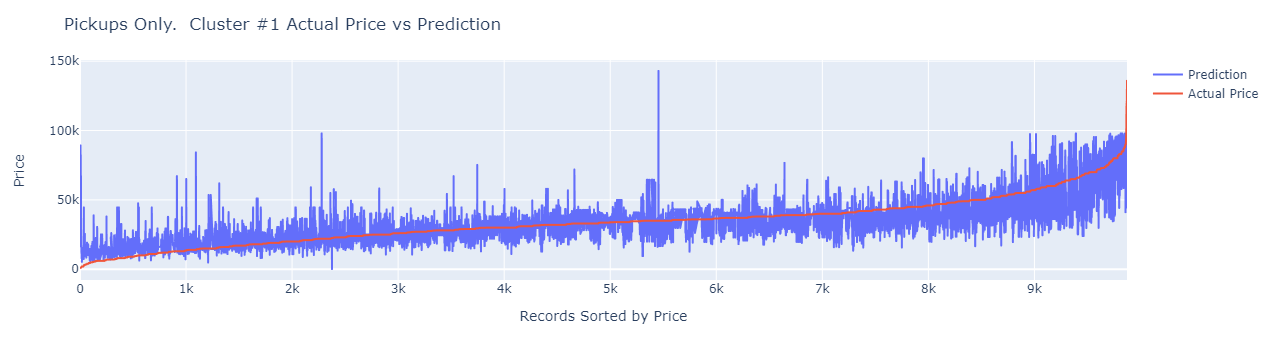

In [87]:
fig = px.line(x=df_plot.sort,y=[df_plot.pred,df_plot.price],labels={"variable": "", "wide_variable_0": "Prediction","wide_variable_1":"Price"})
fig.update_layout(
    title="Pickups Only.  Cluster #1 Actual Price vs Prediction",
    xaxis_title="Records Sorted by Price",
    yaxis_title="Price"
    )
fig.data[1].name = "Actual Price"
fig.data[1].hovertemplate = "Price"
fig.data[0].name = 'Prediction'
fig.data[0].hovertemplate = 'Prediction'
fig.show()
